In [7]:
import numpy as np
import pandas as pd

import lightgbm
import matplotlib.pylab as plt
import os

from sklearn.model_selection import train_test_split
import sklearn

Inserting all features from test into one dataframe

In [8]:
folder_train = '../features_train_in_use'

features_train = pd.read_csv(os.path.join(folder_train, os.listdir(folder_train)[0]))
for i in range(1,len(os.listdir(folder_train))):
    f = os.path.join(folder_train,os.listdir(folder_train)[i])
    if os.path.isfile(f):
        features_train = pd.concat([features_train, pd.read_csv(f)], axis=1)
print(features_train)
        
        

       average_income_per_grunnkrets  C_1.1.1.0  C_1.1.2.0  C_1.1.3.0  \
0                           561700.0          1          0          0   
1                           555720.0          1          0          0   
2                           495900.0          1          0          0   
3                           521240.0          1          0          0   
4                           585360.0          1          0          0   
...                              ...        ...        ...        ...   
12854                       505640.0          0          0          0   
12855                       396640.0          0          0          0   
12856                       549120.0          0          0          0   
12857                       498660.0          0          0          0   
12858                       579780.0          0          0          0   

       C_1.1.4.0  C_1.1.5.0  C_1.1.6.1  C_1.1.6.2  C_1.1.6.3  C_1.1.6.4  ...  \
0              0          0          0     

Repeat for test features

In [9]:
folder_test = '../features_test_in_use'

features_test = pd.read_csv(os.path.join(folder_test, os.listdir(folder_test)[0]))
for i in range(1,len(os.listdir(folder_test))):
    f = os.path.join(folder_test,os.listdir(folder_test)[i])
    if os.path.isfile(f):
        features_test = pd.concat([features_test, pd.read_csv(f)], axis=1)
print(features_test)
    

      average_income_per_grunnkrets  C_1.1.1.0  C_1.1.2.0  C_1.1.3.0  \
0                          551600.0          1          0          0   
1                          531240.0          1          0          0   
2                          523300.0          1          0          0   
3                          591380.0          1          0          0   
4                          594020.0          1          0          0   
...                             ...        ...        ...        ...   
8572                       560700.0          0          0          0   
8573                       593340.0          0          0          0   
8574                       629100.0          0          0          0   
8575                       590100.0          0          0          0   
8576                       529980.0          0          0          0   

      C_1.1.4.0  C_1.1.5.0  C_1.1.6.1  C_1.1.6.2  C_1.1.6.3  C_1.1.6.4  ...  \
0             0          0          0          0        

Target train data:

In [10]:
target_train = pd.read_csv("../data/stores_train.csv")
target_train = target_train['revenue'].values

#log transform
target_train = np.log1p(target_train)

Light GBM model:

In [11]:
lgbm_model = lightgbm.LGBMRegressor(
    num_leaves=4,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=1000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [12]:
features_train["categorical_chain_name"] = features_train["categorical_chain_name"].astype("category")
features_train["categorical_mall_name"] = features_train["categorical_mall_name"].astype("category")
features_train["categorical_plaace"] = features_train["categorical_plaace"].astype("category")
features_train["categorical_sales_channel_name"] = features_train["categorical_sales_channel_name"].astype("category")
features_train["categorical_street"] = features_train["categorical_street"].astype("category")

KeyError: 'categorical_chain_name'

In [ ]:
features_test["categorical_chain_name"] = features_test["categorical_chain_name"].astype("category")
features_test["categorical_mall_name"] = features_test["categorical_mall_name"].astype("category")
features_test["categorical_plaace"] = features_test["categorical_plaace"].astype("category")
features_test["categorical_sales_channel_name"] = features_test["categorical_sales_channel_name"].astype("category")
features_test["categorical_street"] = features_test["categorical_street"].astype("category")

In [ ]:
lgbm_model.fit(features_train, target_train)
lgbm_predictions = lgbm_model.predict(features_test)

#Undo log transform
lgbm_predictions = np.expm1(lgbm_predictions)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


In [ ]:
print(lgbm_predictions)

[7.97657424 5.48866172 1.93081266 ... 3.31715029 3.52754302 2.0735683 ]


In [ ]:
stores_test = pd.read_csv("../data/stores_test.csv")
stores_test_id = stores_test['store_id'].values

In [ ]:
predictions = pd.DataFrame()

predictions['id'] = stores_test_id
predictions['predicted'] = lgbm_predictions
predictions.to_csv("../predictions/lightGBM21.csv", index=False)
print(predictions)


                              id  predicted
0     914206820-914239427-717245   7.976574
1     916789157-916823770-824309   5.488662
2       913341082-977479363-2948   1.930813
3      889682582-889697172-28720   5.455493
4     997991699-998006945-417222   6.686180
...                          ...        ...
8572  917323003-917383529-844309   2.637809
8573  917353379-917411824-845904   3.412953
8574  917072302-917089248-833647   3.317150
8575  916960557-916993161-829908   3.527543
8576   987280891-972040746-45320   2.073568

[8577 rows x 2 columns]


In [ ]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))


X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

lgbm_model2 = lightgbm.LGBMRegressor(
    num_leaves=4,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=1000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

lgbm_model2.fit(X_train, y_train)
y_pred = lgbm_model2.predict(X_test)
# Calculate rmsle for a few example predictions 
y_true = y_test
n = len(features_train)
print('A couple of RMSLE scores computed over the train set')
print(f'Perfect prediction: {rmsle(y_true, y_true):.4f}')
print(f'Score: {rmsle(y_true, y_pred):.4f}')

print("Score: ",sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


A couple of RMSLE scores computed over the train set
Perfect prediction: 0.0000
Score: 0.3206
Score:  0.3206189175314278


In [ ]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


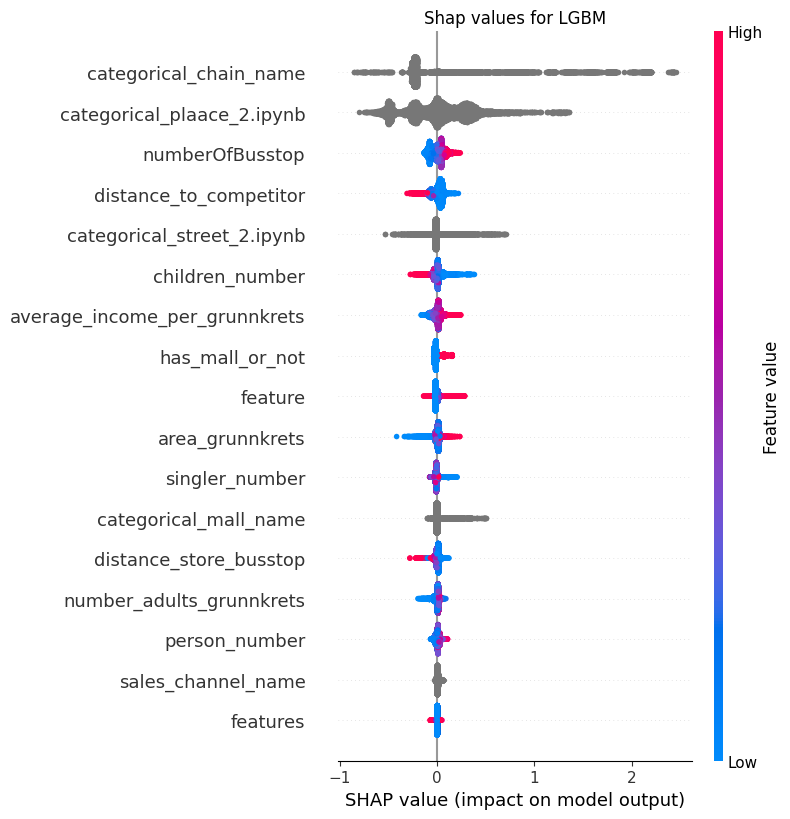

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(features_train)

plt.title('Shap values for LGBM')
shap.summary_plot(shap_values, features_train)